In [1]:
import pandas as pd
import gensim
import csv
import datetime as dt
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Preparation and Cleaning

In [66]:
path = './messages.txt'
output_path = './messages2.csv'

#going through text file line by line
with open(output_path, 'a', encoding='utf-8') as csvfile:
    fieldnames = ['Text', 'Date', 'Time', 'Sender']
    writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
    with open(path, 'r', encoding='utf-8') as f:
        text = ""
        for l in f.readlines():
            if len(l) > 0:
                if l[0].isdigit() and '-' in l:
                    datetime = l.split('-')[0]
                    date = datetime.split(',')[0]
                    time = datetime.split(',')[1].strip()
                    text = ""
                    text += l.split('-')[1]
                    msg = text.split(': ')[1]
                    sender = text.split(': ')[0].strip()

                else:
                    text = text + " " + l
            writer.writerow({'Text': msg, 'Date': date, 'Time':time, 'Sender': sender}) 

In [2]:
#Data from 28 July 2017 to 7 Oct 2020
fieldnames = ['Text', 'Date', 'Time', 'Sender']
df = pd.read_csv('messages2.csv', names = fieldnames)

In [6]:
#hiding our names, only using first letter to represent them
def substring(string, start, end):
    return string[start:end]
    
df['Sender'] = df.apply(lambda row: substring(row.Sender, 0,1) , axis=1) 

In [7]:
df.head()

,Text,Date,Time,Sender
0,"I found an APJite in my class, today\r\n",28/07/17,7:36 pm,J
1,"But, he joined the school after I left\r\n",28/07/17,7:36 pm,J
2,Ho\r\n,28/07/17,7:37 pm,D
3,Oh.\r\n,28/07/17,7:37 pm,D
4,He's a 🆒 guy\r\n,28/07/17,7:40 pm,J


In [8]:
df = df.drop_duplicates()

In [9]:
#messages deleted by J
df[df['Text'] == "This message was deleted\r\n" ]

,Text,Date,Time,Sender
6079,This message was deleted\r\n,31/10/17,9:54 pm,J
6087,This message was deleted\r\n,31/10/17,9:56 pm,J
6088,This message was deleted\r\n,31/10/17,9:57 pm,J
8116,This message was deleted\r\n,25/11/17,4:16 pm,J
8118,This message was deleted\r\n,25/11/17,4:19 pm,J
...,...,...,...,...
40556,This message was deleted\r\n,30/04/20,6:45 pm,J
41061,This message was deleted\r\n,21/06/20,8:15 pm,J
41062,This message was deleted\r\n,21/06/20,8:16 pm,J
41416,This message was deleted\r\n,19/09/20,1:34 pm,J


In [10]:
#messages I deleted
df[df['Text'] == "You deleted this message\r\n" ]

,Text,Date,Time,Sender
7733,You deleted this message\r\n,18/11/17,4:09 am,D
8021,You deleted this message\r\n,25/11/17,12:05 am,D
8026,You deleted this message\r\n,25/11/17,12:15 am,D
8698,You deleted this message\r\n,05/12/17,11:08 pm,D
9045,You deleted this message\r\n,10/12/17,9:33 pm,D
...,...,...,...,...
39286,You deleted this message\r\n,05/11/19,7:50 pm,D
40478,You deleted this message\r\n,18/04/20,9:02 pm,D
40938,You deleted this message\r\n,11/06/20,2:07 pm,D
41327,You deleted this message\r\n,07/09/20,9:05 pm,D


In [11]:
#the WhatsApp export option I used omitted media files, so some records are like this
df[df['Text'] == "<Media omitted>\r\n" ]

,Text,Date,Time,Sender
108,<Media omitted>\r\n,29/07/17,12:27 am,J
113,<Media omitted>\r\n,29/07/17,12:29 am,J
114,<Media omitted>\r\n,29/07/17,12:29 am,D
195,<Media omitted>\r\n,29/07/17,12:51 am,D
197,<Media omitted>\r\n,29/07/17,9:55 am,D
...,...,...,...,...
41391,<Media omitted>\r\n,18/09/20,3:33 pm,D
41401,<Media omitted>\r\n,18/09/20,9:40 pm,J
41408,<Media omitted>\r\n,19/09/20,9:04 am,J
41409,<Media omitted>\r\n,19/09/20,9:25 am,J


In [12]:
#Getting rid of deleted messages and the escape sequences at the ends of each text
#We'll get rid of the media texts once we look at messaging frequency
df = df[df['Text'] != "You deleted this message\r\n"]
df = df[df['Text'] != "This message was deleted\r\n" ]

In [13]:
#who sent more links? I did. Typical.
links = df[df['Text'].str.contains("https*", case=False) == True]
links.groupby("Sender")["Sender"].count()

Sender
D    274
J    266
Name: Sender, dtype: int64

## Word occurences

We can see how often a certain word has been used, and by whom. For example, let's look at who uses the word "lol" more.

In [15]:
lols = df[df['Text'].str.contains("lol", case=False) == True]
lols

,Text,Date,Time,Sender
540,"But atleast, he did it. If I were in his place...",02/08/17,11:46 pm,J
673,"Can barely eat food, lol.\r\n",06/08/17,2:10 pm,J
1342,Lol no\r\n,27/08/17,12:51 am,D
1769,Lol no. T'was raining. Plus most of my friends...,04/09/17,12:40 am,D
2213,You guys seem to have a lot of ample time on y...,13/09/17,5:08 pm,J
...,...,...,...,...
41299,Lol tbh I didn't really create a character for...,04/09/20,9:52 am,D
41545,But all that's minor compared to tinnitus lol\r\n,04/10/20,4:10 pm,J
41551,Lol\r\n,04/10/20,4:12 pm,J
41563,Lol\r\n,06/10/20,2:46 pm,J


In [16]:
#J lols more than I do
lols.groupby("Sender")["Sender"].count()

Sender
D     72
J    196
Name: Sender, dtype: int64

In [109]:
#Number of texts sent in this period
df.Text.count()

39642

In [25]:
df.groupby("Sender")["Sender"].count()

Sender
D    19424
J    20218
Name: Sender, dtype: int64

In [3]:
#Number of words
df['Text'].str.split().str.len().sum()

237115

### Insights so far:
A total 39642 texts sent in this time period! J has sent 20221 texts, I've sent 19428. A total of 237115
words exchanged!

Breakdown by type:
* 596 media files shared - 450 by J, 146 by me
* 540 links shared - 266 him, 274 me
* 147 deleted messages - 82 by J, 65 by me

Oh, and J says lol way more than I do.

In [17]:
#creatinng a timestamp column by combining date and time, later convert this to datetime object for time-series viz
df['Timestamp'] = df.apply(lambda row: row.Date + " " + row.Time, axis=1) 

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39649 entries, 0 to 41665
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       39642 non-null  object
 1   Date       39649 non-null  object
 2   Time       39649 non-null  object
 3   Sender     39649 non-null  object
 4   Timestamp  39649 non-null  object
dtypes: object(5)
memory usage: 1.8+ MB


In [18]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst =True)

In [19]:
df.head()

,Text,Date,Time,Sender,Timestamp
0,"I found an APJite in my class, today\r\n",28/07/17,7:36 pm,J,2017-07-28 19:36:00
1,"But, he joined the school after I left\r\n",28/07/17,7:36 pm,J,2017-07-28 19:36:00
2,Ho\r\n,28/07/17,7:37 pm,D,2017-07-28 19:37:00
3,Oh.\r\n,28/07/17,7:37 pm,D,2017-07-28 19:37:00
4,He's a 🆒 guy\r\n,28/07/17,7:40 pm,J,2017-07-28 19:40:00


In [189]:
#We exchanged 552 messages on 5th March 2018? 
#No way...I had to go back to the Excel to figure it out - we were up till 3 AM that night lol
df.groupby("Date")["Date"].count().sort_values()

Date
31/12/19      1
08/08/19      1
08/07/20      1
23/09/19      1
08/02/18      1
           ... 
24/10/18    391
02/07/18    395
16/07/18    425
01/01/18    488
05/03/18    552
Name: Date, Length: 772, dtype: int64

In [21]:
#noticed a few null cells, should have done this earlier
df = df[df['Text'].isnull()==False]

In [22]:
#getting read of the escape characters at the end of texts
df['Text'] = df.apply(lambda row: row.Text.split('\r\n')[0], axis=1)

<ipython-input-22-33c86b2e0ccb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df.apply(lambda row: row.Text.split('\r\n')[0], axis=1)


In [23]:
df.head()

,Text,Date,Time,Sender,Timestamp
0,"I found an APJite in my class, today",28/07/17,7:36 pm,J,2017-07-28 19:36:00
1,"But, he joined the school after I left",28/07/17,7:36 pm,J,2017-07-28 19:36:00
2,Ho,28/07/17,7:37 pm,D,2017-07-28 19:37:00
3,Oh.,28/07/17,7:37 pm,D,2017-07-28 19:37:00
4,He's a 🆒 guy,28/07/17,7:40 pm,J,2017-07-28 19:40:00


In [2]:
#convert to csv for later use
df.to_csv('cleaned_messages.csv', index = False)
#df = pd.read_csv('cleaned_messages2.csv')

# Messaging Frequency

In [219]:
#Messaging Frequency
messages_per_day = df.groupby(pd.Grouper(key="Timestamp", freq='D')).count()

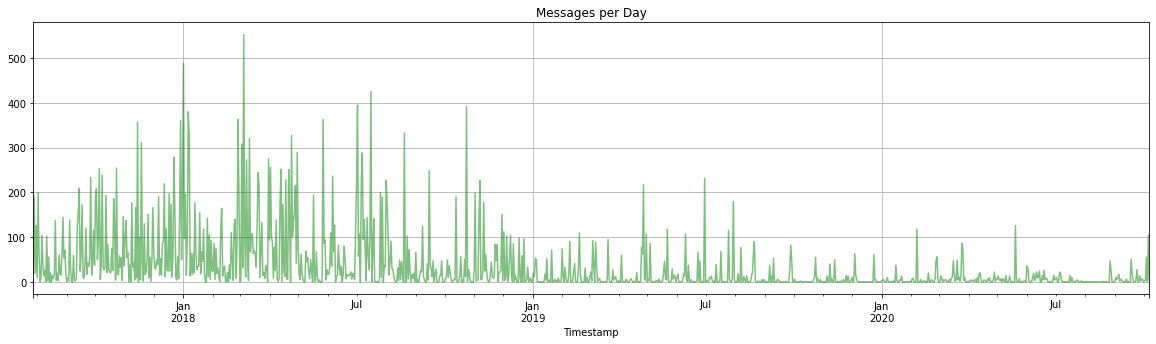

In [221]:
messages_per_day.Text.plot(figsize=(20,5),style='g',alpha=0.5, title = "Messages per Day", grid = True)

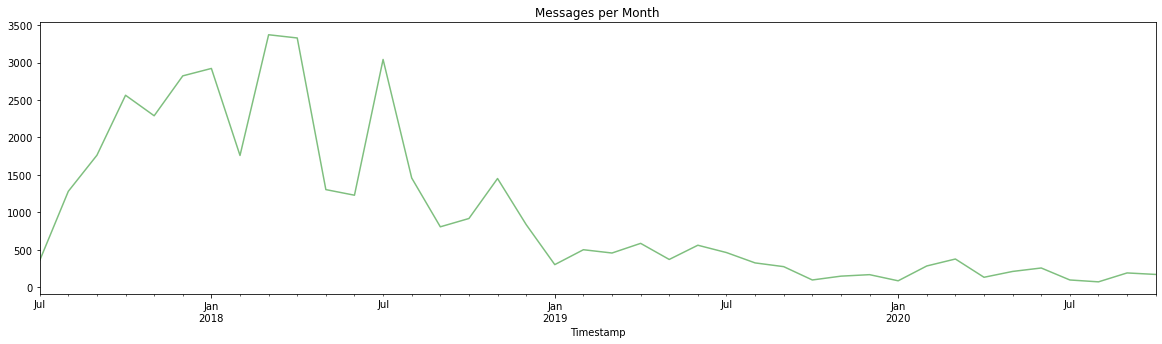

In [224]:
messages_per_month = df.groupby(pd.Grouper(key="Timestamp", freq='M')).count()

messages_per_month.Text.plot(figsize=(20,5),style='g',alpha=0.5, title = "Messages per Month", grid = False)

In [238]:
#Total days we texted during this period (1167 days total)
#This is almost 20 days in a month
df.Date.unique().size

772

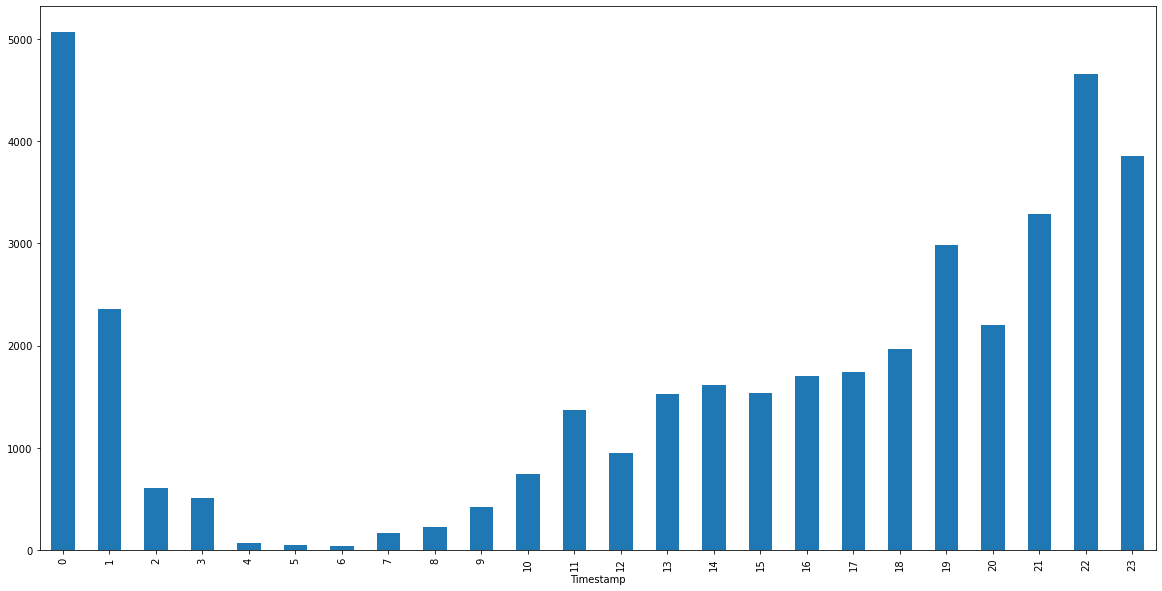

In [245]:
#Let's look at activitiy by time of day
df.groupby([df.Timestamp.dt.hour]).Text.count().plot(kind='bar',figsize=(20,10))

# Vocabulary

In [30]:
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
#from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
from wordcloud import WordCloud, ImageColorGenerator

In [31]:
def normalize(text, join_sentences = True, stops = True, stemmer = False):
    if type(text) not in [type(''),type(u'')]:
        return text
    r = RegexpReplacer()
    p_stemmer = PorterStemmer()
    word_punct_tokenizer = WordPunctTokenizer()
    repeat = RepeatReplacer()
    x = re.compile('[%s]' % re.escape(string.punctuation))
    if stops:
        stops = set(stopwords.words('english'))
    sentences = sent_tokenize(text)
    normalized_sentences = []
    for sentence in sentences:
        #tokens = word_tokenize(r.replace(sentence.lower()))
        tokens = word_punct_tokenizer.tokenize(r.replace(sentence.lower()))
        no_punct = [token for token in tokens if x.sub(u'', token)]
        no_repeat = [replacer.replace(word) for word in no_punct]
        if stops:
            no_repeat = [word for word in no_repeat if word not in stops]
        if stemmer:
            no_repeat = [p_stemmer.stem(word) for word in no_repeat]
        normalized_sentences.append(' '.join(no_repeat))
    if join_sentences:
        normalized_sentences = ' '.join(normalized_sentences)
        return normalized_sentences
    return [normalized_sentence for normalized_sentence in normalized_sentences]

In [32]:
replacement_patterns = [
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'ain\'t', 'is not'),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+)\'s', '\g<1> is'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would'),
    (r'gonna','going to'),
    (r'wanna','want to')
]
class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns):
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in
        patterns]
    def replace(self, text):
        s = text
        for (pattern, repl) in self.patterns:
            (s, count) = re.subn(pattern, repl, s)
        return s

In [33]:
class RepeatReplacer(object):
    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'
    def replace(self, word):
        if len(word) > 100:
            return ''
        if wordnet.synsets(word):
            return word
        repl_word = self.repeat_regexp.sub(self.repl, word)
        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word

In [34]:
replacer = RepeatReplacer()

In [32]:
#get rid of links and "media omitted" messages so as to not affect NLP tasks

In [20]:
df2 = df[df['Text'] != "<Media omitted>"]
df2 = df[df.Text.str.contains("https*")==False]

In [21]:
df2['text_normalized'] = df2.Text.apply(normalize)

<ipython-input-21-d82683a6d5bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['text_normalized'] = df2.Text.apply(normalize)


In [22]:
x = df2.Text.dropna()

In [23]:
top_50 = pd.Series(' '.join(x).split()).value_counts()[:50]

In [32]:
#most frequently used words
top_50

I         7722
the       6998
a         5112
to        4074
of        3198
it        3131
you       2788
in        2566
and       2557
that      2507
was       2192
for       1847
is        1691
have      1632
on        1593
this      1487
my        1411
like      1240
Oh        1225
Yeah      1216
It's      1180
The       1088
with      1045
I've       972
one        953
don't      946
are        937
just       915
about      868
But        855
from       854
me         847
I'm        817
be         794
not        766
I'll       765
at         751
You        732
Yeah,      727
And        726
It         718
really     717
all        717
get        709
they       679
do         670
it's       667
too        651
know       643
some       636
dtype: int64

In [18]:
#length of longest message sent
df.Text.str.len().max()

1412

In [39]:
df2 = df[df['Sender'] != "J"]

In [24]:
#D's longest message
df2.Text.str.len().max()

1412

In [27]:
#J's longest message
df2 = df[df['Sender'] == "J"]
df2.Text.str.len().max()

1025

In [40]:
df2 = df2[df2['Text'] != "<Media omitted>"]
df2 = df2[df2.Text.str.contains("https*")==False]
df2['text_normalized'] = df2.Text.apply(normalize)

In [37]:
#J's most used words
x = df2.Text.dropna()
top_100 = pd.Series(' '.join(x).split()).value_counts()[:100]
top_100

the          3837
I            3746
a            2648
to           1967
of           1907
             ... 
watch         191
Have          191
then          189
But,          188
something     185
Length: 100, dtype: int64

In [41]:
#D's most used words
x = df2.Text.dropna()
top_100 = pd.Series(' '.join(x).split()).value_counts()[:100]
top_100

I       3976
the     3161
a       2464
to      2107
and     1451
        ... 
did      164
your     163
by       161
here     157
no       156
Length: 100, dtype: int64

# Emoji Usage

In [46]:
import regex
import emoji
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

#New col with list of emojis used in the text
df["emoji"] = df["Text"].apply(split_count)

In [27]:
df.head()

,Text,Date,Time,Sender,Timestamp,emoji
0,"I found an APJite in my class, today",28/07/17,7:36 pm,J,2017-07-28 19:36:00,[]
1,"But, he joined the school after I left",28/07/17,7:36 pm,J,2017-07-28 19:36:00,[]
2,Ho,28/07/17,7:37 pm,D,2017-07-28 19:37:00,[]
3,Oh.,28/07/17,7:37 pm,D,2017-07-28 19:37:00,[]
4,He's a 🆒 guy,28/07/17,7:40 pm,J,2017-07-28 19:40:00,[🆒]


In [49]:
#2253 emojis sent over 4 years
sum(df['emoji'].str.len())

2253

In [24]:
l = ['D', 'J']

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= df[df["Sender"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)

Stats of D -
Emojis Sent 895
Stats of J -
Emojis Sent 1358


In [63]:
total_emojis_list = list(set([a for b in df.emoji for a in b]))
total_emojis = len(total_emojis_list)
#Number of unique emojis used
print(total_emojis)

484


In [65]:
from collections import Counter
total_emojis_list = list([a for b in df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😆,164
1,😂,148
2,🤣,96
3,💯,67
4,😝,53
...,...,...
479,🦾,1
480,🤏,1
481,⌛,1
482,🎎,1


In [76]:
emoji_df.head(10)

,emoji,count
0,😆,164
1,😂,148
2,🤣,96
3,💯,67
4,😝,53
5,🤔,50
6,🆒,42
7,🤭,42
8,💦,31
9,😳,31


In [75]:
dummy_df = df[df['Sender'] == 'J']
total_emojis_list = list([a for b in dummy_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print('Emoji Distribution for J')
emoji_dict

Emoji Distribution for J


[('🤣', 92),
 ('😆', 80),
 ('😂', 67),
 ('💯', 62),
 ('😝', 52),
 ('🤔', 42),
 ('🆒', 39),
 ('🤭', 28),
 ('😳', 28),
 ('👏🏻', 25),
 ('🐖', 23),
 ('👌🏻', 22),
 ('😉', 22),
 ('💦', 19),
 ('👍🏻', 18),
 ('🤤', 17),
 ('🅱', 15),
 ('😅', 14),
 ('😱', 14),
 ('☹', 13),
 ('👉🏻', 13),
 ('➡', 12),
 ('🐾', 10),
 ('🤯', 10),
 ('🥵', 10),
 ('🗿', 10),
 ('❤', 9),
 ('👣', 9),
 ('👒', 9),
 ('⛰', 9),
 ('💧', 8),
 ('🌟', 8),
 ('🐽', 8),
 ('😋', 8),
 ('😕', 7),
 ('🕶', 7),
 ('🤑', 7),
 ('🏎', 7),
 ('🕷', 7),
 ('🇳🇵', 7),
 ('🙄', 6),
 ('🔥', 6),
 ('🔘', 6),
 ('👙', 6),
 ('🦔', 6),
 ('💪🏾', 6),
 ('💪🏻', 6),
 ('👅', 6),
 ('😃', 5),
 ('🥀', 5),
 ('😎', 5),
 ('💰', 5),
 ('😘', 5),
 ('😨', 5),
 ('⭐', 4),
 ('😁', 4),
 ('✔', 4),
 ('🧟\u200d♂', 4),
 ('🍆', 4),
 ('👬', 4),
 ('😜', 4),
 ('😚', 4),
 ('🤫', 4),
 ('🙁', 4),
 ('👏', 4),
 ('👌', 4),
 ('☯', 4),
 ('🌐', 4),
 ('🥴', 4),
 ('😐', 3),
 ('🤦🏻\u200d♂', 3),
 ('✅', 3),
 ('🤰🏻', 3),
 ('🤪', 3),
 ('📷', 3),
 ('🍌', 3),
 ('🙈', 3),
 ('🤗', 3),
 ('👄', 3),
 ('👁', 3),
 ('🧡', 3),
 ('💛', 3),
 ('💚', 3),
 ('💙', 3),
 ('💜', 3),
 ('🖤', 3),
 ('😙'

In [74]:
dummy_df = df[df['Sender'] == 'D']
total_emojis_list = list([a for b in dummy_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print('Emoji Distribution for D')
emoji_dict

Emoji Distribution for D


[('😆', 84),
 ('😂', 81),
 ('🦎', 28),
 ('🕙', 25),
 ('🤷\u200d♂', 21),
 ('🤦\u200d♂', 20),
 ('👍', 19),
 ('🤭', 14),
 ('😅', 13),
 ('💩', 13),
 ('🕤', 13),
 ('🧖\u200d♂', 13),
 ('💦', 12),
 ('🧖🏿\u200d♂', 11),
 ('👌', 9),
 ('🍌', 9),
 ('🕳', 9),
 ('🅱', 9),
 ('🤔', 8),
 ('😐', 8),
 ('🕘', 8),
 ('🕥', 8),
 ('🕜', 7),
 ('🍆', 6),
 ('👙', 6),
 ('🕝', 6),
 ('🕣', 6),
 ('🍪', 6),
 ('❤', 5),
 ('🇮🇳', 5),
 ('😁', 5),
 ('🐜', 5),
 ('👉', 5),
 ('🥚', 5),
 ('👄', 5),
 ('♥', 5),
 ('🕠', 5),
 ('🥥', 5),
 ('🧟\u200d♂', 5),
 ('💯', 5),
 ('😖', 4),
 ('🔥', 4),
 ('🤣', 4),
 ('🚆', 4),
 ('💋', 4),
 ('💿', 4),
 ('🐖', 4),
 ('🥕', 4),
 ('💨', 4),
 ('💪', 4),
 ('🆒', 3),
 ('😳', 3),
 ('😍', 3),
 ('😓', 3),
 ('🧐', 3),
 ('🤪', 3),
 ('👃', 3),
 ('😛', 3),
 ('😤', 3),
 ('🥨', 3),
 ('🇦🇶', 3),
 ('🎉', 3),
 ('💪🏾', 3),
 ('🕹', 3),
 ('😷', 3),
 ('😵', 2),
 ('😴', 2),
 ('👏', 2),
 ('😎', 2),
 ('🖕', 2),
 ('😕', 2),
 ('🚅', 2),
 ('😿', 2),
 ('💰', 2),
 ('🙇🏽\u200d♂', 2),
 ('🥜', 2),
 ('🗿', 2),
 ('👻', 2),
 ('🍼', 2),
 ('🌙', 2),
 ('📀', 2),
 ('🔍', 2),
 ('🔎', 2),
 ('🐽', 2),
 ('🐘', 2),
 ('👂